# Diagnostics: select point and make time series


A notebook to demonstrate the usage of an implemented plotting function in Valenspy

In [1]:
import valenspy as vp
from valenspy._utilities import load_yml
from valenspy.preprocessing_tasks.select import select_point

from pathlib import Path

from valenspy.preprocessing_tasks.select import sel_region

import warnings
import xarray as xr

# Turn off all warnings
warnings.filterwarnings('ignore')


# define machine name - used for paths of (observational) datasets
machine = 'hortense'

## 0. Settings

In [2]:
model = 'CCLM'
ref_dataset = 'ERA5'
variable = 'tas'

## 1. Loading data

### 1.1 Model data

To be replaced with automatic input manager returning the ds

In [3]:
# get lookup file for model
mod_LOOKUP = load_yml(model+"_lookup")
mod_var = mod_LOOKUP[variable]['raw_name']

experiment = "EUR11_CO_TA_GC_TSO"
postproc_base_dir = "/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/"

# define the path
directory = Path(postproc_base_dir + experiment +'/'+mod_var + '/daily/')

# define the CCLM files for the corresponding variable
mod_files = list(directory.glob(mod_var+"_daymean.nc")) # Select all the netCDF files in the directory
    
ds_mod = xr.open_mfdataset(mod_files, combine="by_coords", chunks="auto")

# renaming to be able to compare
ds_mod = ds_mod.rename({mod_var:variable})
ds_mod.attrs['dataset'] = model
ds_mod[variable].attrs['dataset'] = model

### 1.2. Load reference data

here we will use ERA5

In [4]:
manager = vp.InputManager(machine=machine)

ds_obs = manager.load_data(ref_dataset, variable, period=[1995,1995], freq="hourly", region="europe")


File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/2m_temperature/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']


## 2. Preprocessing: point  & time selection 
in this example, this means selecting the point data and corresponding time

In [5]:
# define points to abstract (lon, lat)
d_point_coords = {
    'opwijk'    : (4.18, 50.97), 
    'betrix'    : (5.25, 49.854),
    'north_sea' : (2.465, 51.63),
}

point_id = "opwijk"
point_coord = d_point_coords[point_id]

In [6]:
# 1. time selection
# resample ERA5 hourly data to daily
ds_obs = ds_obs.resample(time='1D').mean()    

# for both datasets, select summer months (JJA)
ds_mod = ds_mod.sel(time=ds_mod.time.dt.month.isin([6,7,8]))
ds_obs = ds_obs.sel(time=ds_obs.time.dt.month.isin([6,7,8]))

# make sure both Datasets have the same daily time axis
ds_mod['time'] = ds_mod['time'].dt.floor('D')
ds_obs['time'] = ds_obs['time'].dt.floor('D')

In [7]:
# do point selection
ds_obs_point = select_point(ds_obs, point_coord)

# CCLM has rotated coordinates - so before extracting grid points, convert coordinates to rotated grid. 
ds_mod_point = select_point(ds_mod, point_coord, rotated_pole=True)



## 3. Diagnostic: do the plotting

In [8]:
from valenspy.diagnostic_functions import *
from valenspy.diagnostic_visualizations import *

<Axes: title={'left': '2m temperature', 'center': ' '}, xlabel='time', ylabel='2m temperature [K]'>

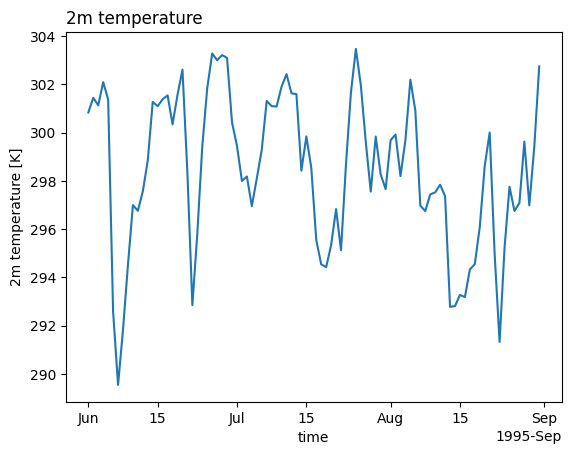

In [9]:
da_mod_point = ds_mod_point[variable]
da_obs_point = ds_obs_point[variable]


# first with the simple timeseries plotting function
plot_time_series(da_mod_point)

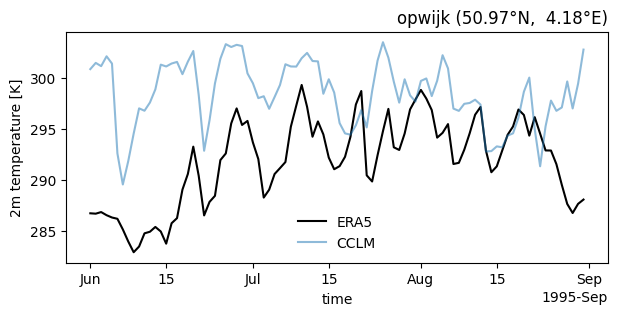

In [10]:
# then with the more sophisticated plot_time_series_mod_ref

fig, ax = plt.subplots(figsize = (7,3))
ax = plot_time_series_mod_ref(da_mod_point, da_obs_point, ax = ax, title='  ')
ax.set_title(f"{point_id} ({point_coord[1]}°N,  {point_coord[0]}°E)", loc='right'); 


In [11]:
# now with the diagnostic Temporal Bias object

from valenspy.diagnostic import TemporalBias
print(TemporalBias.description)

Temporal Bias (Model2Ref)
The temporal bias of the data compared to the reference.
 Diagnostic function: temporal_bias
 Calculate the temporal bias of the data compared to the reference. If lat and lon are present, ds and ref is averaged over the spatial dimensions lat and lon.

    Parameters
    ----------
    ds : xr.Dataset
        The data to calculate the temporal bias of.
    ref : xr.Dataset
        The reference data to compare the data to.
    calc_relative : bool, optional
        If True, return the relative bias, if False return the absolute bias, by default False

    Returns
    -------
    xr.Dataset
        The temporal bias of the data compared to the reference.
    
 Visualization function: plot_time_series
 
    Plot a time series from an xarray DataArray.

    Parameters
    ----------
    da : xarray.DataArray
        The DataArray containing the time series data to plot.
    ax : matplotlib.axes.Axes, optional
        The axes on which to plot the time series. If

<Axes: title={'left': '2m temperature', 'center': ' '}, xlabel='time', ylabel='2m temperature [K]'>

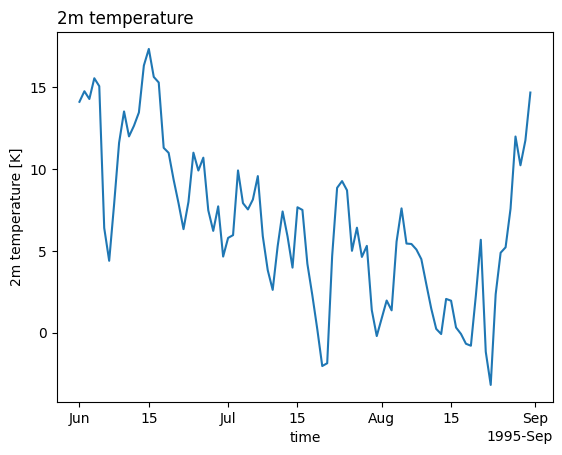

In [12]:
ds_bias = TemporalBias.apply(ds_mod_point, ds_obs_point).compute()

TemporalBias.plot(ds_bias[variable])

### Plot a map of the defined points

<GeoAxes: title={'right': 'Location of points'}>

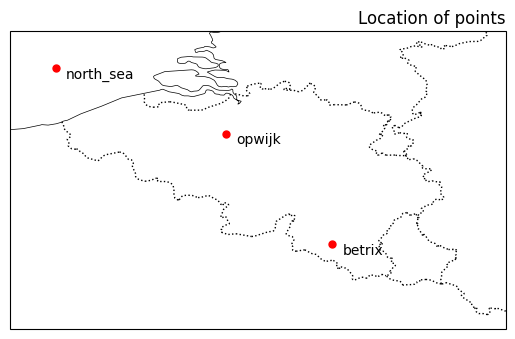

In [13]:
plot_points_on_map(d_point_coords, region="belgium")